# Quick start with HTL API

## Setup
Install the Signal Ocean SDK:
```
pip install signal-ocean
```
Set your subscription key acquired here: https://apis.signalocean.com/profile

In [1]:
signal_ocean_api_key = '' #replace with your subscription key

## Example 1 - Plotting a supply trend
In this demo is presented how a user can query with a few lines of code the HTL API and generate an aggegated view on the supply trend.

The data frame format makes it very easy to generate a supply trend plot.

We'll generate a supply trend from 10 days, but we'll also filter the vessel list by looking for vessels that:
- are pushed, poss_pushed,
- have a market deployment type of "Relet" or "Spot",
- their commercial status is available, cancelled or failed,
- are crude oil tankers (their vessel subclass is "Dirty"),
- their AIS information is no older than 5 days.

Filtering can be achieved by creating an instance of a `VesselFilter` and passing it to the `get_historical_tonnage_list` method. A `VesselFilter` meeting the above criteria will look as follows:

In [2]:
from datetime import date, timedelta,time
from signal_ocean import PortAPI, VesselClassAPI,PortFilter,VesselClassFilter,Connection
from signal_ocean.historical_tonnage_list import VesselFilter, PushType, MarketDeployment, CommercialStatus, VesselSubclass
from signal_ocean.historical_tonnage_list import HistoricalTonnageListAPI

connection = Connection(signal_ocean_api_key)

port_api = PortAPI(connection)
vessel_class_api = VesselClassAPI(connection)
htl_api = HistoricalTonnageListAPI(connection)
vessel_class = vessel_class_api.get_vessel_classes(VesselClassFilter(name_like='aframax'))[0]
port = port_api.get_ports(PortFilter(name_like='escravos'))[0]
laycanEndInDays = 20
start_date = date.today() - timedelta(days=5)
end_date = date.today()

vessel_filter = VesselFilter(
    push_types=[PushType.PUSHED, PushType.PUSHED_POSS],
    market_deployments=[MarketDeployment.RELET, MarketDeployment.SPOT],
    commercial_statuses=[CommercialStatus.AVAILABLE, CommercialStatus.CANCELLED, CommercialStatus.FAILED],
    vessel_subclass=VesselSubclass.DIRTY,
    latest_ais_since=5
)


currentHour = datetime.utcnow().time().hour
last_existing_snapshot = (currentHour // 6) *6

htl_for_supply_trend = htl_api.get_historical_tonnage_list(
    port,
    vessel_class,
    laycanEndInDays,
    start_date,
    end_date,
    vessel_filter=vessel_filter,
    time=time(hour=last_existing_snapshot)
)

supply_trend_data_frame = htl_for_supply_trend.to_data_frame()

supply_trend_data_frame

name vessel_class ice_class  \
date                      imo                                               
2020-08-12 06:00:00+00:00 9592288       Indigo Sun      Aframax       NaN   
                          9422407        Pichincha      Aframax       NaN   
                          9773040  Victory Venture      Aframax       NaN   
                          9417024     Eagle Kangar      Aframax       NaN   
                          9458016       Delta Star      Aframax       NaN   
...                                            ...          ...       ...   
2020-08-07 06:00:00+00:00 9411185     Ise Princess      Aframax       NaN   
                          9417440             Ohio      Aframax       NaN   
                          9252371          Maratha      Aframax       NaN   
                          9527855         Alicante      Aframax       NaN   
                          9592264   Nissos Serifos      Aframax       NaN   

                                   year_built  deadweight  length_overall  \
date                      imo                                               
2020-08-12 06:00:00+00:00 9592288        2012      115724          248.97   
                          9422407        2010      105093          244.25   
                          9773040        2017      115000          247.00   
                          9417024        2010      107481          243.80   
                          9458016        2013      109990          248.97   
...                                       ...         ...             ...   
2020-08-07 06:00:00+00:00 9411185        2009      105361          228.60   
                          9417440        2009      105188          243.97   
                          9252371        2003      105995          244.00   
                          9527855        2013      115707          248.97   
                          9592264        2012      115688          248.97   

                                   breadth_extreme subclass  \
date                      imo                                 
2020-08-12 06:00:00+00:00 9592288               44    Dirty   
                          9422407               41    Dirty   
                          9773040               44    Dirty   
                          9417024               42    Dirty   
                          9458016               44    Dirty   
...                                            ...      ...   
2020-08-07 06:00:00+00:00 9411185               42    Dirty   
                          9417440               42    Dirty   
                          9252371               42    Dirty   
                          9527855               45    Dirty   
                          9592264               45    Dirty   

                                  market_deployment_point_in_time  \
date                      imo                                       
2020-08-12 06:00:00+00:00 9592288                            Spot   
                          9422407                            Spot   
                          9773040                           Relet   
                          9417024                           Relet   
                          9458016                            Spot   
...                                                           ...   
2020-08-07 06:00:00+00:00 9411185                            Spot   
                          9417440                           Relet   
                          9252371                            Spot   
                          9527855                            Spot   
                          9592264                           Relet   

                                  push_type_point_in_time  ...  \
date                      imo                              ...   
2020-08-12 06:00:00+00:00 9592288                  Pushed  ...   
                          9422407                  Pushed  ...   
                          9773040                  Pushed  .

Now, we can generate the plot:

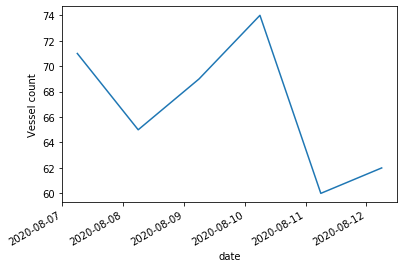

In [3]:
from signal_ocean.historical_tonnage_list import IndexLevel

supply_trend = supply_trend_data_frame.groupby(IndexLevel.DATE, sort=True).size()
plot = supply_trend.plot()
plot.set_ylabel('Vessel count')

plot

## Example 2 - Generating an Excel sheet
The data frame can be easily saved as an Excel file by using Pandas's built-in `to_excel()` function.

Before we do that, we need to remove all the time zone information from all the timestamps in the data frame. This is because Excel does not support storing time zone information along with timestamps. However, Signal Ocean's SDK always provides time zone information to make all timestamp-based computation unambiguous.

In [4]:
from signal_ocean.historical_tonnage_list import Column

without_time_zones = (
    supply_trend_data_frame
        .reset_index()
        .astype({ IndexLevel.DATE: 'datetime64[ns]', Column.OPEN_DATE: 'datetime64[ns]', Column.ETA: 'datetime64[ns]', Column.LATEST_AIS: 'datetime64[ns]'})
        .set_index([IndexLevel.DATE, IndexLevel.IMO])
 )

Now, we can generate the Excel file:

In [5]:
without_time_zones.to_excel('simpleDemo.xlsx')